
B. Recreate the previous exercise but simulate an AR(p) process of your choice. Experiment
with a third- or fourth-order autoregressive process. I would recommend generating
10,000 samples.
When forecasting, experiment with different values for the window parameter of
your rolling_forecast function. How does it affect the model’s perforARnce? Is
there a value that minimizes the MSE?

In [1]:
from statsmodels.tsa.ariAR_process import ArARProcess
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sariARx import SARIARX
import ARtplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [4]:
np.random.seed(151)

ar4 = np.array([1,0.5,0.4,0.3,0.4])
AR4 = np.array([1,0,0,0,0])

ar4_process = ArARProcess(ar=ar4,AR=AR4).generate_sample(10000)


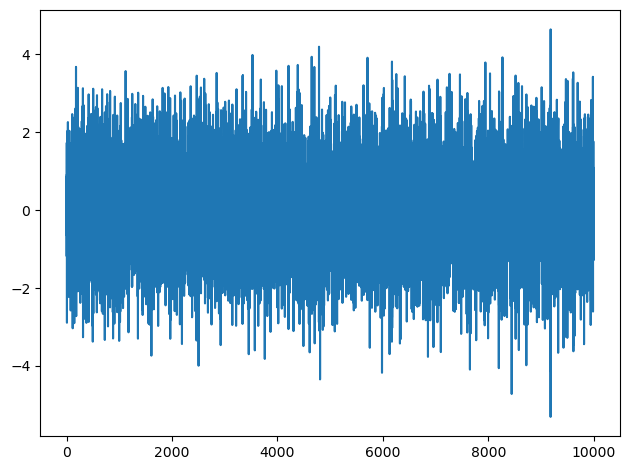

In [5]:
#Plot your simulated ar4 process.

plt.plot(ar4_process)
plt.tight_layout()

In [8]:
# Run the ADF test and check if the process is stationary. If not, apply differencing
adf_result = adfuller(ar4_process)

print(f"ADF_Stat: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF_Stat: -95.41485282177203
p-value: 0.0


##### The process is stationary. It has a high negative value of adf_statistic and p value is less than 0.05 i.e 0.

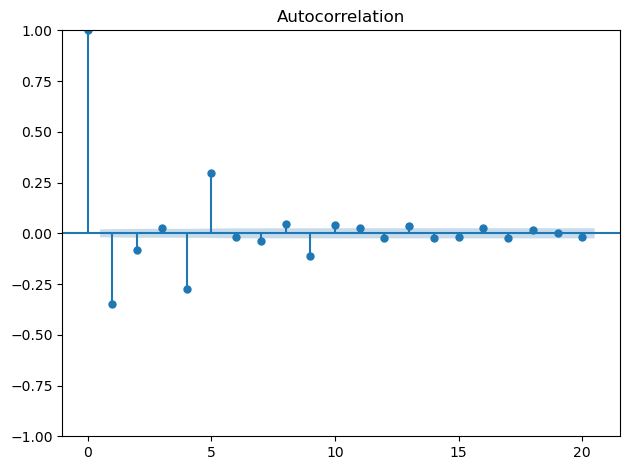

In [9]:
# Plot the ACF. Is it slowly decaying?
plot_acf(ar4_process, lags=20)
plt.tight_layout()

In [13]:
#### The process is not slowly decaying and also the coefficients doesnt end after certain lags. Let's check the pacf.

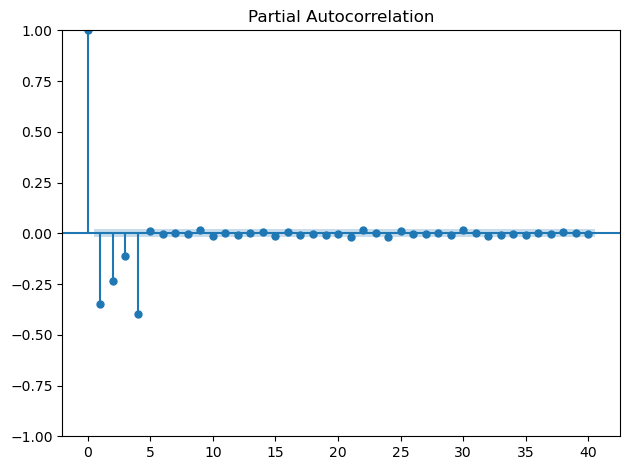

In [11]:
plot_pacf(ar4_process)
plt.tight_layout()

The process doesnot have significant coefficients after lag4.

In [14]:
# Separate your simulated series into train and test sets. Take the first 9500 timesteps for the train set, and assign the rest to the test set.

train = ar4_process[:9500]
test = ar4_process[9500:]

In [21]:
# Make forecasts over the test set. Use the mean, last value, and an AR(4) model.
# Make sure you repeatedly forecast 4 timesteps at a time using the recursive_forecast function we defined.

In [16]:
def rolling_forecast(data: np.array, train_len: int, horizon: int, window: int, method: str)-> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len,total_len,window):
            mean = np.mean(data[0:i])
            # calculate the mean for the whole train data until that index and populate it for the next window length records as forecasted value
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    if method == 'last':
        pred_last = []
        for i in range(train_len,total_len,window):
            last_value = data[:i][-1]
            pred_last.extend(last_value for _ in range(window))

        return pred_last
    
    if method == 'AR':
        pred_AR = []
        for i in range(train_len,total_len,window):
            model = SARIARX(data[:i],order=(4,0,0))
            results = model.fit(disp = True)
            predictions = results.get_prediction(0,i+window-1)
            # get the predictions for all the data plus window size(4 in this case)
            # The last window size number of predictions are the out of sample predictions
            oos_pred = predictions.predicted_mean[-window:]
            # print(oos_pred)
            pred_AR.extend(oos_pred)
        return pred_AR
    



In [17]:
import pandas as pd
pred_df = pd.DataFrame({'value':test}, index= range(9500,10000))

# arguments for the rolling forecast function
Train_len = len(train)
Horizon = len(test)
Window = 4

pred_mean = rolling_forecast(ar4_process,Train_len,Horizon,Window,'mean')
pred_last = rolling_forecast(ar4_process,Train_len,Horizon,Window,'last')
pred_AR = rolling_forecast(ar4_process,Train_len,Horizon,Window,'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last
pred_df['pred_AR'] = pred_AR

pred_df.head()


,value,pred_mean,pred_last_value,pred_AR
9500,-3.278022,0.002184,0.149052,-0.916796
9501,-0.800900,0.002184,0.149052,-0.220931
9502,-2.250750,0.002184,0.149052,-0.171065
9503,3.322438,0.002184,0.149052,0.380120
9504,2.009726,0.001867,3.322438,0.745523


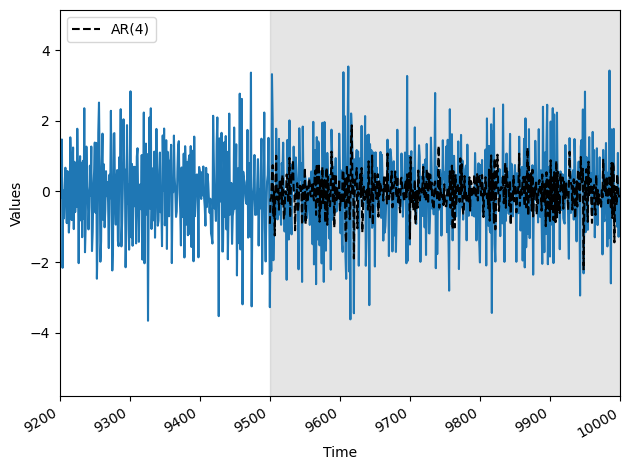

In [22]:
fig, ax = plt.subplots()

ax.plot(ar4_process)
# ax.plot(pred_df['value'], 'b-', label='actual')
# ax.plot(pred_df['pred_mean'], 'g:', label='mean')
# ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_AR'], 'k--', label='AR(4)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Values')

ax.axvspan(9500, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9200,10000)

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

1.5127235888232349 3.427469956333802 1.2705169793379885


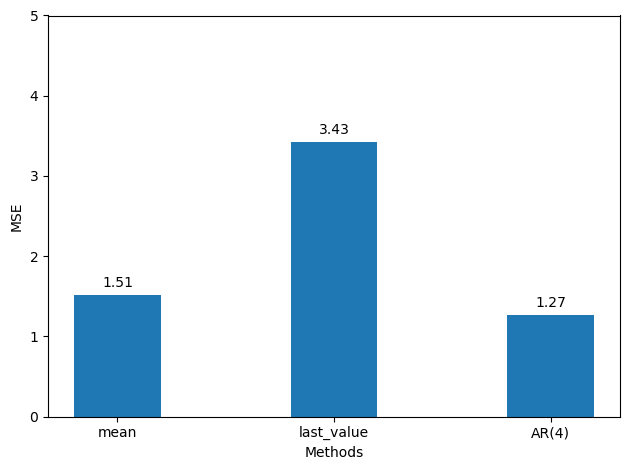

In [20]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(4)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()



AR4 model gave the least mean_squared_error, It can be considered to be the best model.